# Gene NER using PySysrev and Human Review (Part II)
<span style="color:gray">James Borden</span>

<span style="color:gray">Nole Lin</span>

In this series on the Sysrev tool, we build a Named Entity Recognition (NER) model for genes.  We use data from 2000 abstracts reviewed in the sysrev [Gene Hunter project](sysrev.com/p/3144). This second part of the series describes how users can use the spaCy.io library to train a model to detect gene names in text.

In this notebook we:

1. **Train Annotations** using text from the Gene Hunter project
2. **Test Model** on example text to check its performance

## Train Annotations

After formatting our annotations and text, we are ready to train a NER model for genes. To begin, we load in our processed json file, `processed_output.json`, derived from the previous post. We then use the spaCy library and its Language class as our model implementation. Following the example NER model documented [here](https://github.com/explosion/spacy/blob/master/examples/training/train_ner.py), we first create an empty model using `spacy.blank` and specify our language as English. Then we shuffle and loop over the examples in our training set. For each example, we update the model by calling `nlp.update`, which steps through the words of the input. At each word, the model makes a prediction. It then consults the annotations to see whether it was right. If it was wrong, it adjusts its weights so that the correct action will score higher next time. Finally, we save our trained model to the directory `sysrev_gene`.

In [ ]:
import PySysrev
PySysrev.trainAnnotations(input_path='processed_output.json', output_dir='sysrev_gene')

Below we have a plot showing the decreasing model loss with each iteration of training.

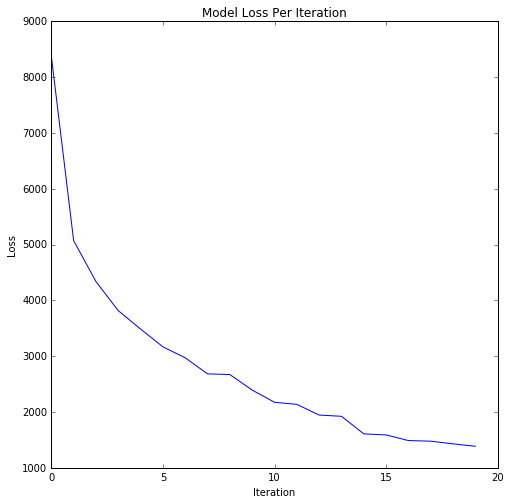

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('model_loss.png')
imgplot = plt.imshow(img)
plt.show()

## Test Model

Taking our trained model, we would like to see how it performs on a toy example text. Below, we see that the model is able to accurately identify two genes, Nup98 and Wdr82, in the sentence. Note that H3K4me3 is correctly excluded since it is not a gene, but our model did incorrectly leave out Set1A, which is a gene. However, the results are encouraging and demonstrate the model's ability to locate genes in text.

In [3]:
from __future__ import unicode_literals
import spacy

test_text = "Depletion of Nup98 or Wdr82 abolishes Set1A recruitment to chromatin and subsequently ablates H3K4me3 at adjacent promoters."

nlp2 = spacy.load('sysrev_gene')
doc2 = nlp2(test_text)
for ent in doc2.ents:
    print(ent.label_, ent.text)

(u'GENE', u'Nup98')
(u'GENE', u'Wdr82')


Given our resulting model, we can move forward and apply it to our project's texts to extract gene terms. We will show the process in the next post.